In [1]:
!nvidia-smi
!pip install python-arango==7.2.0
!pip install openai
!pip install git+https://github.com/salesforce/LAVIS.git
!pip install sumy
!pip install word2number
import nltk
nltk.download('punkt')
#!pip install nebula3_database
#!mkdir /notebooks/cache

Wed Feb 22 08:49:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:05.0 Off |                  Off |
| N/A   39C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/notebooks/cache/'
import torch
from PIL import Image
import openai
from arango import ArangoClient
import requests # request img from web
import shutil # save img locally
from lavis.models import load_model_and_preprocess
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from word2number import w2n


In [9]:
#add your api key 

In [24]:
dbname = "ipc_200"
arango_host = "http://172.83.9.249:8529"

In [98]:
class BLIP2():
    def __init__(self):
        self.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
        self.question_model, self.question_vis_processors, question_text_processors = load_model_and_preprocess(name="blip2_t5", model_type="pretrain_flant5xxl", is_eval=True, device=self.device)
        self.match_model, self.match_vis_processors, self.match_text_processors = load_model_and_preprocess("blip2_image_text_matching", "pretrain", device=self.device, is_eval=True)

class BLIP2GPTDialog():
    def __init__(self, db_name, db_host, blip):
        self.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
        client = ArangoClient(hosts=db_host)
        self.db = client.db(db_name, username='nebula', password='nebula')
        self.prompt_step1 = """The text below is an inaccurate image caption. 
        Ask 15 different clarifying questions to get more accurate information that can be seen in the image:
        
        """
        self.prompt_step1_1 = """The text below is an image caption. 
        Ask 5 different clarifying questions to get more details that can be seen in the image:
        
        """
        #self.prompt_step2 = "Text below With the provided weak and inaccurate captions for the image, taking into account clarifying questions and answers to them, write more accurate detailed captions for the same image: \n\n"
        self.prompt_step2 = """The following text contains weak descriptions of the image, which may contain incorrect, inaccurate or irrelevant information. 
        Taking in account clarifying questions and answers about this image, provide an accurate and detailed captions of it: 
        
        """
        self.question_model =  blip.question_model
        self.question_vis_processors = blip.question_vis_processors
        self.match_model = blip.match_model
        self.match_vis_processors = blip.match_vis_processors
        self.match_text_processors = blip.match_text_processors
    
    def sumy_sum(self, captions, count):
        LANGUAGE = "english"
        SENTENCES_COUNT = int(count)
        prompt = []
        parser = PlaintextParser.from_string(captions, Tokenizer(LANGUAGE))    
        stemmer = Stemmer(LANGUAGE)

        summarizer = Summarizer(stemmer)
        summarizer.stop_words = get_stop_words(LANGUAGE)

        for sentence in summarizer(parser.document, SENTENCES_COUNT):
            prompt.append(str(sentence))
        return(prompt)

    def get_mdfs(self, movie_id):
        mdfs = []
        for res in self.db.collection("s4_llm_output").find({'movie_id': movie_id}):
            mdfs.append(res)
        newlist = sorted(mdfs, key=lambda d: d['frame_num'])
        return(newlist)
    
    def get_persons_bboxes(self, movie_id, frame_num):
        persons = []
        for res in self.db.collection("s4_visual_clues").find({'movie_id': movie_id, 'frame_num': frame_num}):
            for roi in res['roi']:
                if roi['bbox_object'] == 'person':
                    rois = []
                    rois_str = roi['bbox'].replace("\"", "").replace("[", "").replace("]","").split(",")
                    for r in rois_str:
                        rois.append(float(r))
                    print("DEBUG ", rois)
                    persons.append(rois)
        return(persons)
        #s4_visual_clues

    def download_file(self, url):
        file_name = "/tmp/" + url.split("/")[-1] #prompt user for file_name
        #print(file_name)
        res = requests.get(url, stream = True)

        if res.status_code == 200:
            with open(file_name,'wb') as f:
                shutil.copyfileobj(res.raw, f)
            print('Image sucessfully Downloaded: ',file_name)
        else:
            print('Image Couldn\'t be retrieved')
        return(file_name)
    
    def ask_gpt(self, prompt, text):
        prompt = prompt + "\n"
        prompt = prompt + text
        try:
            response = openai.Completion.create(
            engine="text-davinci-003",
            prompt=prompt,
            temperature=0.0,
            max_tokens=256,
            #top_p=1.0,
            frequency_penalty=0.0,
            presence_penalty=0.0
            )
            #print(response['choices'][0]['text'])
            return(response['choices'][0]['text'])
        except Exception as e:
            print(e)
            return("No answer from OpenAI, please re-try in few minutes")
    
    def process_image_and_captions(self, movie_id, frame):
        mdfs = {}
        for mdf in self.get_mdfs(movie_id):
            if mdf['frame_num'] == frame:
                mdfs = mdf
        mdf_file = self.download_file(mdfs['url']) 
        # load sample image
        raw_image = Image.open(mdf_file).convert("RGB")
        #raw_image.crop()
        display(raw_image.resize((596, 437)))
        question_image = self.question_vis_processors["eval"](raw_image).unsqueeze(0).to(self.device)
        match_image = self.match_vis_processors["eval"](raw_image).unsqueeze(0).to(self.device)
        all_captions = "" 
        
        for para in mdfs['paragraphs']:
            #print(para)a
            all_captions = all_captions + " " + para
        all_captions = mdfs['candidate'] + " " + all_captions
        sum_captions = self.sumy_sum(all_captions, 30) 
        #print(sum_captions)
        captions = "" 
        for sentence in sum_captions:
            #for sentence in sentences.split(". "):          
            txt = self.match_text_processors["eval"](sentence)
            itm_output = self.match_model({"image": match_image, "text_input": txt}, match_head="itm")
            itm_scores = torch.nn.functional.softmax(itm_output, dim=1)
            if  itm_scores[:, 1].item() >= 0.3:
                captions = captions +  sentence + "\n"
                #print("Good ", sentence, " ", itm_scores[:, 1].item())
            #else:
                #print("Bad ", sentence, " ", itm_scores[:, 1].item())
        return(question_image, match_image, raw_image, captions, all_captions)

    def get_questions(self, captions):
        #Human related question -> ask only if there are people in the image
        human_related = []
        human_related.append("Question: How many people are in the picture? Answer: ")
        human_related.append("Question: How are the people in the picture different from each other? Answer:")
        human_related.append("Question: What outerwear are the people in the picture wearing? Answer:")
        human_related.append("Question: How old is the man shown first from the right in the picture? Answer:")
        human_related.append("Question: How old is the man shown second from the right in the picture? Answer:")
        human_related.append("Question: What color is the outerwear of the people in the picture? Answer:")
        human_related.append("Question: What outerwear do the people in the picture have? Answer:")
        human_related.append("Question: What is the person shown first from the right in the picture doing? Answer:")
        human_related.append("Question: What is the person shown second from the right in the picture doing? Answer:")
        human_related.append("Question: What is the moods of the people in the picture? Answer:")
        human_related.append("Question: What are the distinguishing features of people in the picture? Answer:")
        #Common questions
        general_prompts = []  
        general_prompts.append("Question: Where the image is taken in? Answer: ")
        general_prompts.append("Question: What inanimate objects are in the picture? Answer:")
        general_prompts.append("Question: Is there something unusual in the picture? Answer:")
        general_prompts.append("Question: What is backgound in the picture? Answer:")
        #Ask GPT-3 for all possible questions, according to captions we have
        captions = "Captions: \n" + captions + "\n"
        result  = self.ask_gpt(self.prompt_step1, captions)
        questions = ''.join([i for i in result if not i.isdigit()])
        questions = questions.split(".") 
        for question in questions[1::]:
            question = question.replace("\n","") 
            if question:
                general_prompts.append("Question: "  + question.replace("\n","") + " Answer:")
                #print("Question: " + question + " Answer:")   
        return(general_prompts, human_related)
    
    def get_answers(self, generated_questions, human_related, question_image):
        answers = ""  
        have_people = "Question: Are there people in the picture? Answer: "
        answer =  self.question_model.generate({"image": question_image, "prompt": have_people})
        if answer[0] == "yes":
            for question in human_related:
                prompt = answers + question
                answer =  self.question_model.generate({"image": question_image, "prompt": prompt}) 
                answers = answers + question + " " + answer[0] + "\n" 
        for question in generated_questions:
            prompt = answers + question
            answer =  self.question_model.generate({"image": question_image, "prompt": prompt})
            if answer[0] != "no":
                answers = answers + question + " " + answer[0] + "\n" 
        answers = answers + "\n"
        return(answers)
    
    def get_persons_visual_properities(self, raw_image, movie_id, frame_num):
        bboxes = self.get_persons_bboxes(movie_id, frame_num)
        if len(bboxes) > 0:
            for person in bboxes:
                print(person)
                person_image = raw_image.crop(person)
                display(person_image.resize((596, 437)))
                question_image = self.question_vis_processors["eval"](person_image).unsqueeze(0).to(self.device)
                prompt = "Qestion: What kind of clothes is the person in the picture wearing? Answer:"
                answer =  self.question_model.generate({"image": question_image, "prompt": prompt})
                print(answer[0])
                prompt = "Qestion: How is a gender of person in the picture? Answer:"
                answer =  self.question_model.generate({"image": question_image, "prompt": prompt})
                print(answer[0])
                prompt = "Qestion: How old is the person in the picture? Answer:"
                answer =  self.question_model.generate({"image": question_image, "prompt": prompt})
                print(answer[0])
                prompt = "Qestion: What is the person in the picture doing? Answer:"
                answer =  self.question_model.generate({"image": question_image, "prompt": prompt})
                print(answer[0])

    def get_dialog_caption(self, movie_id, frame_num):
        question_image, match_image, raw_image, captions, all_captions = self.process_image_and_captions(movie_id, frame_num)
        #print("BEFORE: ", captions)
        questions, human_related = self.get_questions(captions)
        answers = self.get_answers(questions, human_related, question_image)
        questions_step2 = "Original weak captions: \n" + captions + "\n" + "Clarifying Questions and Answers: \n"+ answers + "\n" + "Accurate captions:"
        print(questions_step2)
        final_results  = self.ask_gpt(self.prompt_step2, questions_step2)
        return(final_results)
        

In [6]:
#print(get_mdfs(movie_id, db))
blip = BLIP2()

  0%|          | 0.00/1.89G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0.00/413M [00:00<?, ?B/s]

  0%|          | 0.00/712M [00:00<?, ?B/s]

In [99]:
dialog = BLIP2GPTDialog(dbname, arango_host, blip)

Image sucessfully Downloaded:  /tmp/frame1078.jpg


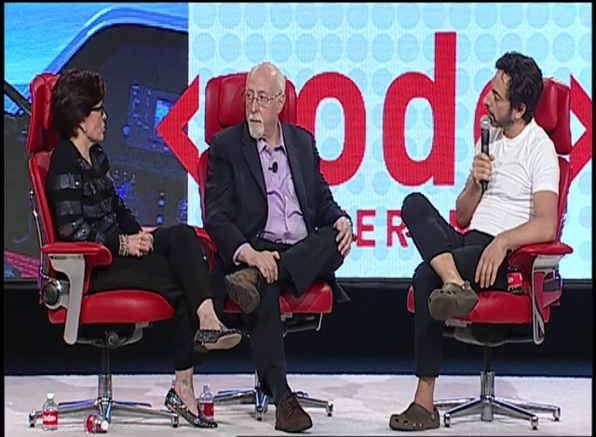

Good  This image shows two people sitting on red chairs in a room with black walls and a large TV screen in the background.   0.8002123832702637
Bad  They appear to be having a conversation and their expressions appear to be very serious.   0.03986380994319916
Good  This image features two people sitting on red-upholstered chairs in front of a studio screen.   0.9597329497337341
Bad  The front of the chairs is decorated with two large white buttons.   9.835776836553123e-06
Bad  Behind the chairs, a room can be seen filled with other people, talking, laughing and getting ready for the show.   0.00025773129891604185
Bad  On the table between the two chairs, there are bottles of different liquids, a white cell phone and a small laptop.   9.190858690999448e-06
Bad  The atmosphere is bright and cheerful, as everyone is about to start a lively conversation.   0.001688044867478311
Good  Two people seated in red chairs discuss something in front of a large screen.   0.99842369556427
Bad  On th

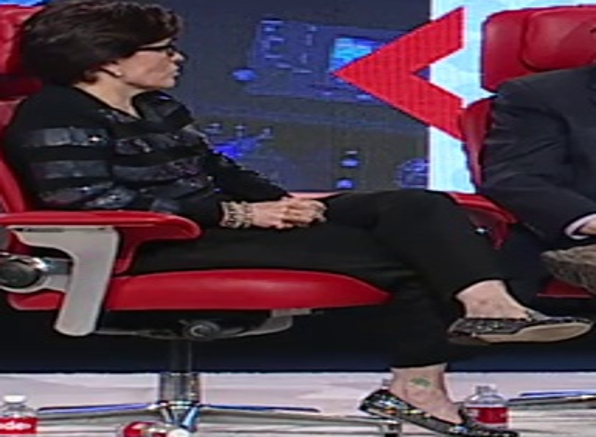

business attire
male and female
58 years old
sitting in a chair
[218.0, 51.0, 380.0, 355.0]


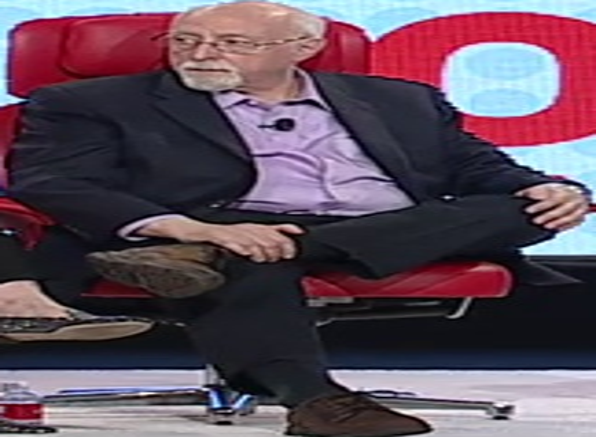

a suit and tie
male
he is 67 years old
sitting in a chair
[416.0, 43.0, 602.0, 356.0]


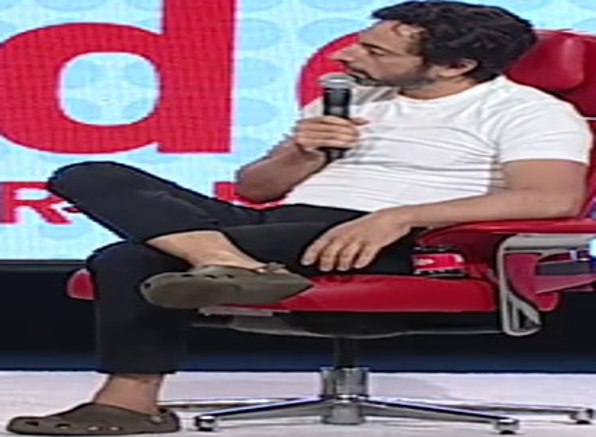

a white shirt and black pants
male
he is 40 years old
talking on a red chair
['[403.0, 72.0, 572.0, 360.0]', '[71.0, 89.0, 275.0, 358.0]', '[233.0, 84.0, 379.0, 358.0]']


In [101]:
movie_id = "Movies/7123356129351484287"
frame_num = 1078
#results = dialog.get_dialog_caption(movie_id, frame_num)
question_image, match_image, raw_image, captions, all_captions = dialog.process_image_and_captions(movie_id, frame_num)
dialog.get_persons_visual_properities(raw_image, movie_id, frame_num)
print(results)